In [1]:
# Import

# Base
import numpy as np 
import pandas as pd 
import os, random, math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
import csv

# DeepLearning
import tensorflow as tf
import keras
import keras.backend as K
from keras.callbacks import Callback
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, plot_model
from keras import Model
from keras.layers import Layer, Input, Embedding, Dropout, SpatialDropout1D
from keras.layers import Bidirectional, GRU, Activation, Dense, LSTM 
from keras.layers import Dot, Reshape, concatenate, BatchNormalization
from keras import initializers, regularizers, constraints
from keras.models import load_model

# Visualizzazione
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import seaborn as sns
sns.set()
from PIL import Image

import warnings
warnings.filterwarnings("ignore")



C:\Users\matte\AppData\Local\Temp\ipykernel_26416\1343678475.py:28: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


funzioni per F1 e visualizzare attention

In [2]:
# Funzioni

# F1 callback
class F1Evaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            y_pred = (y_pred > 0.35).astype(int)
            score = metrics.f1_score(self.y_val, y_pred, average="micro")
            print("\n F1 Score - epoch: %d - score: %.6f \n" % (epoch+1, score))

def make_plot(loss, val_loss, acc, val_acc):            
    t = np.arange(1,len(loss)+1,1)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,3))
    plt.subplots_adjust(wspace=0.2)

    ax1.plot(t, loss)
    ax1.plot(t, val_loss)
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_title('Train vs Val loss')
    ax1.legend(['train','val'], ncol=2, loc='upper right')

    ax2.plot(t, acc)
    ax2.plot(t, val_acc)
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('acc')
    ax2.set_title('Train vs Val acc')
    ax2.legend(['train','val'], ncol=2, loc='upper right')
    
    plt.show();





#visualizzazione attention layer

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
    
def attention2color(attention_score):
    r = 255 - int(attention_score * 255)
    color = rgb_to_hex((255, r, r))
    return str(color)
    
def visualize_attention():
    
    # Predizioni con modello basato su attention, selezione random di sentenza 
    
    model_att = Model(inputs=model_gru.input, \
                            outputs=[model_gru.output, model_gru.get_layer('Meccanismo_Attenzione').output[-1]])
    idx = np.random.randint(low = 0, high=X_te.shape[0]) 
    tokenized_sample = np.trim_zeros(X_te[idx]) 
    label_probs, attentions = model_att.predict(X_te[idx:idx+1]) 

    # decodificazione testo
    id2word = dict(map(reversed, tokenizer.word_index.items()))
    decoded_text = [id2word[word] for word in tokenized_sample] 
    
    # classificazione etichetta con maggiore probabilità
    label = (label_probs>0.5).astype(int).squeeze()
    label2id = ['Rigetto', 'Accoglimento']
    
    # vettore di attenzione usato sulle parole
    token_attention_dic = {}
    max_score = 0.0
    min_score = 0.0
    
    attentions_text = attentions[0,-len(tokenized_sample):]
    plt.bar(np.arange(0,len(attentions.squeeze())), attentions.squeeze())       
    plt.show();
    attentions_text = (attentions_text - np.min(attentions_text)) / (np.max(attentions_text) - np.min(attentions_text))
    for token, attention_score in zip(decoded_text, attentions_text):
        token_attention_dic[token] = attention_score
    
 
 
 
    # HTML per visualizzazione
    html_text = "<hr><p style='font-size: large'><b>Text:  </b>"
    for token, attention in token_attention_dic.items():
        html_text += "<span style='background-color:{};'>{} <span> ".format(attention2color(attention),
                                                                            token)
    html_text += "</p><br>"
    html_text += "<p style='font-size: large'><b>Classificazione:</b> "
    html_text += label2id[label] 
    html_text += "</p>"
    
    # Display text enriched with attention scores 
    display(HTML(html_text))
    
    # barplot con probabilità
    _labels = ['Rigetto', 'Accoglimento']
    probs = np.zeros(2)
    probs[1] = label_probs
    probs[0] = 1- label_probs
    plt.figure(figsize=(5,2))
    plt.bar(np.arange(len(_labels)), probs.squeeze(), align='center', alpha=0.5)
    plt.xticks(np.arange(len(_labels)), _labels)
    plt.ylabel('Scores')
    plt.show()
    
    
#Matrice di embedding

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

def get_embeddings_matrix():
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding="utf8"))

    word_index = tokenizer.word_index
    nb_words = min(MAX_FEATURES, len(word_index))
    print('nb_words: %d' % nb_words)
    embedding_matrix = np.zeros((nb_words, EMB_SIZE))
    print('Embedding matrix shape: %d/%d' % (nb_words, EMB_SIZE))
    for word, i in word_index.items():
        if i >= nb_words: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    return embedding_matrix

attention layer custom

In [3]:
#Layer di attenzione

class Attention(keras.layers.Layer):
    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, return_attention=False,
                 **kwargs):
        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(Attention, self).__init__(**kwargs)


    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True
    
        def compute_mask(self, input, input_mask=None):
       
            return None

    def call(self, x, mask=None):
        eij = K.squeeze(K.dot(x, K.expand_dims(self.W)), axis=-1)

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

       
        if mask is not None:
            a *= K.cast(mask, K.floatx())
            
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        weighted_input = x * K.expand_dims(a)

        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

HYPERPARAMETERS

In [4]:
# Iperparametri

EMB_SIZE = 300
MAX_FEATURES = 50000   
MAX_LEN = 35000 
EMBEDDING_FILE = 'C:/Users/matte/Desktop/testtesi/embita/vectors.txt'  



LOAD AND PREPARE DATA

caricamento dati ita

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matte\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
stpwrd = nltk.corpus.stopwords.words('italian')

parole = []
with open('stopwords.csv', encoding='UTF8', newline='') as inputfile:
    for row in csv.reader(inputfile):
        parole.append(row[0])

In [7]:
stpwrd.extend(parole)

print(stpwrd)

['ad', 'al', 'allo', 'ai', 'agli', 'all', 'agl', 'alla', 'alle', 'con', 'col', 'coi', 'da', 'dal', 'dallo', 'dai', 'dagli', 'dall', 'dagl', 'dalla', 'dalle', 'di', 'del', 'dello', 'dei', 'degli', 'dell', 'degl', 'della', 'delle', 'in', 'nel', 'nello', 'nei', 'negli', 'nell', 'negl', 'nella', 'nelle', 'su', 'sul', 'sullo', 'sui', 'sugli', 'sull', 'sugl', 'sulla', 'sulle', 'per', 'tra', 'contro', 'io', 'tu', 'lui', 'lei', 'noi', 'voi', 'loro', 'mio', 'mia', 'miei', 'mie', 'tuo', 'tua', 'tuoi', 'tue', 'suo', 'sua', 'suoi', 'sue', 'nostro', 'nostra', 'nostri', 'nostre', 'vostro', 'vostra', 'vostri', 'vostre', 'mi', 'ti', 'ci', 'vi', 'lo', 'la', 'li', 'le', 'gli', 'ne', 'il', 'un', 'uno', 'una', 'ma', 'ed', 'se', 'perché', 'anche', 'come', 'dov', 'dove', 'che', 'chi', 'cui', 'non', 'più', 'quale', 'quanto', 'quanti', 'quanta', 'quante', 'quello', 'quelli', 'quella', 'quelle', 'questo', 'questi', 'questa', 'queste', 'si', 'tutto', 'tutti', 'a', 'c', 'e', 'i', 'l', 'o', 'ho', 'hai', 'ha', 'ab

In [8]:
#caricamento dataset

spacy_df = pd.read_csv("C:/Users/matte/Desktop/parseJson/outputData/1.csv")  

#salvataggio dati per utilizzo nell'analisi Lime
lime_Data_text = spacy_df['Text']   
lime_Data_result=spacy_df['Result'] 

#visualizzazione dataset
print("Abbiamo {} sentenze e {} colonne di riferimento. \n".format(spacy_df.shape[0],spacy_df.shape[1]))
spacy_df

Abbiamo 265 sentenze e 4 colonne di riferimento. 



,ID,Text,Result,Created At
0,365,"Ritenuto che, con ordinanza del 25 marzo 2015 ...",Negative,2022-10-09T08:18:45.977380Z
1,364,nel giudizio di legittimità costituzionale deg...,Negative,2022-10-09T08:18:45.977325Z
2,363,nel giudizio di legittimità costituzionale del...,Positive,2022-10-09T08:18:45.977252Z
3,362,L'Azienda Territoriale per l'Edilizia Residenz...,Negative,2022-10-09T08:18:45.977122Z
4,361,ricorso numero di registro generale 1709 del 2...,Negative,2022-10-09T08:18:45.977015Z
...,...,...,...,...
260,105,AVVISO DI ACCERTAMENTO n. I.M.U. 2016 AVVISO D...,Negative,2022-10-09T07:28:37.929894Z
261,104,Il Comune di S. impugna con un unico motivo la...,Positive,2022-10-09T07:28:37.929808Z
262,103,AVVISO DI ACCERTAMENTO n. I.M.U. 2014 a seguit...,Negative,2022-10-09T07:28:37.929726Z
263,102,"La sig.ra omissis , con l'assistenza tecnica ...",Positive,2022-10-09T07:28:37.929673Z


LINEA DA ELIMINARE

linea da eliminare

linea da eliminare

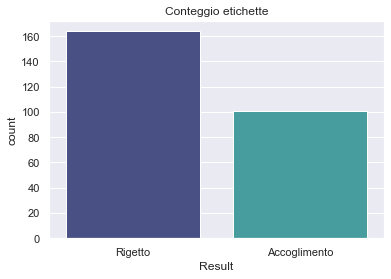

In [9]:
#conversione etichette per comprensione e conteggio

spacy_df['Result'].replace({'Negative':"Rigetto", 'Positive':"Accoglimento"} ,inplace=True)


sns.countplot(spacy_df['Result'],palette="mako")
plt.title("Conteggio etichette")
plt.savefig("conteggio.png", dpi=300)

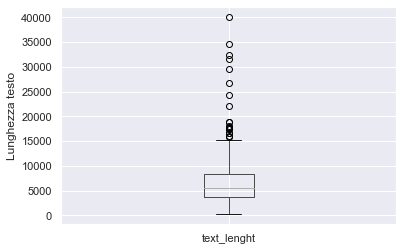

In [10]:
spacy_df['text_lenght'] = spacy_df['Text'].map(str).apply(len)
text_lunghezza=spacy_df['text_lenght']
spacy_df.boxplot("text_lenght")
plt.ylabel("Lunghezza testo")
plt.savefig("boxplot.png", dpi=300)

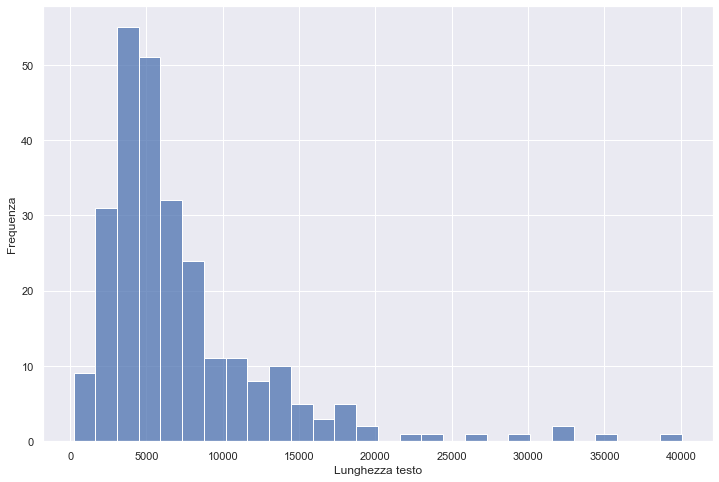

In [11]:
plt.figure(figsize=(12,8))
sns.histplot(text_lunghezza,palette="deep")
plt.xlabel("Lunghezza testo")
plt.ylabel("Frequenza")
plt.savefig("barplot.png", dpi=300)

In [12]:
from cgitb import text
import spacy
from spacy.lang.it.examples import sentences 
from nltk.tokenize import word_tokenize
import re


#load spacy e lemmatizer

nlp = spacy.load("it_core_news_lg", disable=['parser','ner','tagger','tok2vec'])

def lemmatizer(text):        
    sent = []
    doc = nlp(text)
    for word in doc:
        sent.append(word.lemma_)
    return " ".join(sent)







#Definizione funzione con lista di task per pulire il testo

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace("'"," ") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    tokens= word_tokenize(cleantext, language='italian')
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stpwrd]
    lemma_words=[lemmatizer(w) for w in filtered_words]
    return " ".join(lemma_words)



#pulizia testo

spacy_df['clean_text']=spacy_df['Text'].map(lambda s:preprocess(s)) 


spacy_df['clean_text'][0]


'ordinanza 2015 r.o 219 2015 massa carrara sollevato questioni legittimità legge istitutiva municipale propria riferimento artt cost rimettente colpendo reddito virtuale immobile produrlo violerebbe principio capacità contributiva art cost . prescindere percezione reddito proprietario bene chiamato adempiere obbligazione indipendentemente disponibilità finanziarie sufficienti pagare costretto svendere bene ricorrere forme finanziamento penalizzanti rilasciare immobile luce ultime considerazioni contrasterebbe art cost . impedirebbe mantenimento proprietà acquistata titolo successorio soggetti privi reddito potrebbero destinare immobile abitazione personale riferisce adito silenzio rifiuto aulla formatosi ordine istanze restituzione versato titolo 2012 2013 onde rimettente rilevanza questione intervenuto consiglio ministri rappresentato generale anzitutto eccepito inammissibilità questioni sollevate atteso ordinanza individuerebbe esattamente disposizioni censurate offrirebbe adeguata r

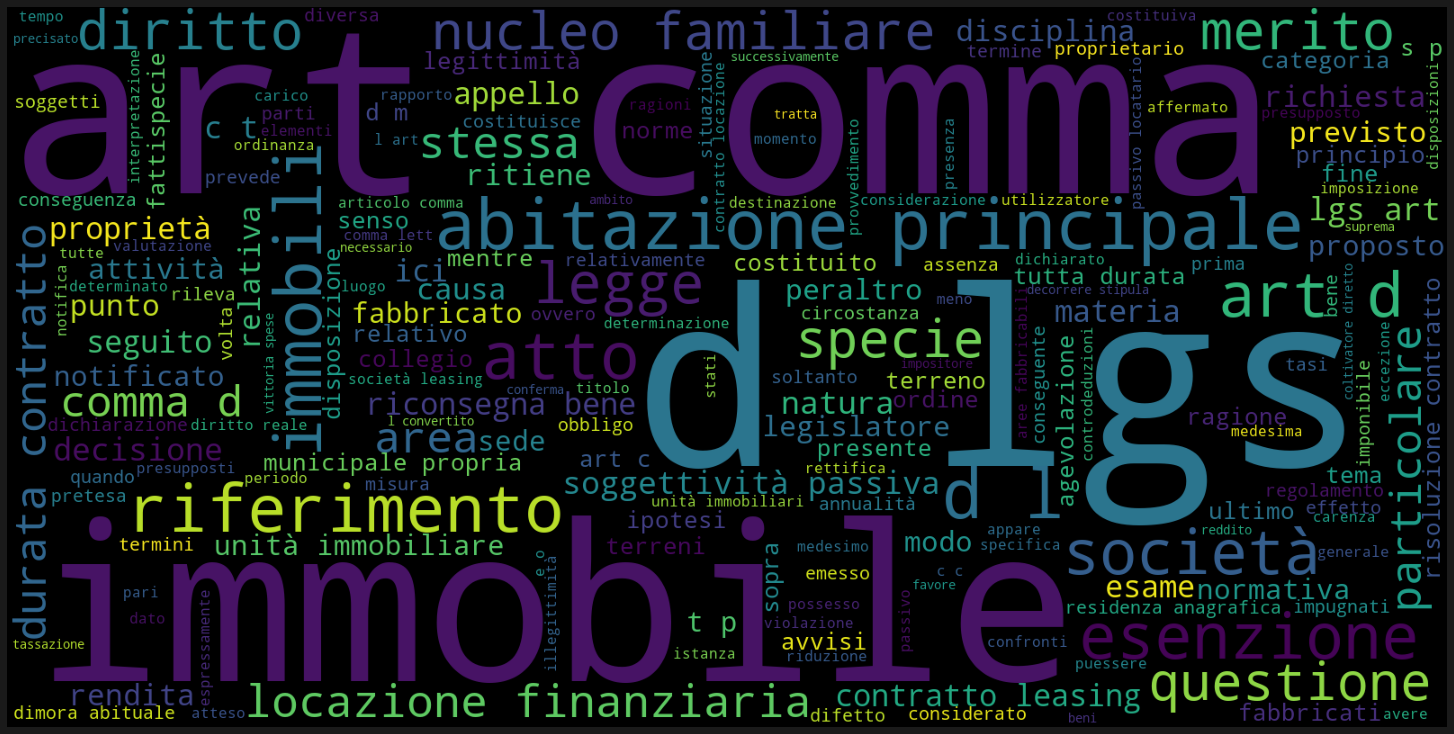

<Figure size 432x288 with 0 Axes>

In [13]:
from wordcloud import WordCloud, ImageColorGenerator


testo=spacy_df["clean_text"].values

wordcloud = WordCloud(width=1600, height=800).generate(str(testo))
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()
plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight')

delete

delete

delete

delete

delete

delete

In [14]:
n_gram_df=spacy_df

#conversione etichette in 0-1
spacy_df['Result'].replace({'Rigetto':0, 'Accoglimento':1} ,inplace=True)


#suddivisione train, validation, split

train_df, test_df = train_test_split(spacy_df, test_size=0.25)   #random_state=2018
test_df, val_df = train_test_split(train_df, test_size=0.5)     #, random_state=2018


X_tra=train_df["clean_text"]
X_te=test_df["clean_text"]
X_val=val_df["clean_text"]

Y_tra=train_df['Result'] 
Y_te=test_df['Result']
Y_val=val_df['Result']


In [15]:
X_tra

223    atto 25/09/2019 sede legale legale rappresenta...
229    impugnati 2013 pubblica svolta modalità remoto...
239    impugnati 2012 2013 2014 2015 2016 separali ri...
226    svolgimento processo avvisi n.n 3448075/2019 3...
74     ... 2016 ... 2013 ... 2014 concisa esposizione...
                             ...                        
76     impugnati 2012 emetteva confronti società s.r....
66     ... 2012- ... 2013- ... 2014- ... 2015contro p...
95     ... 2013- ... 2014- ... 2015svolgimento proces...
158    svolgimento processo tempestivo immobiliare ze...
231    2014 2014 2014 2014hanno accertamenti rettific...
Name: clean_text, Length: 198, dtype: object

In [16]:
#tokenizzazione

tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(list(X_tra))

X_tra = tokenizer.texts_to_sequences(X_tra)
X_val = tokenizer.texts_to_sequences(X_val)
X_te = tokenizer.texts_to_sequences(X_te)

X_tra[0]


[16,
 932,
 440,
 25,
 130,
 410,
 410,
 866,
 626,
 1687,
 120,
 495,
 733,
 25,
 343,
 36,
 44,
 5,
 644,
 16,
 220,
 221,
 4678,
 6381,
 32,
 106,
 1476,
 89,
 6382,
 32,
 161,
 1968,
 32,
 200,
 32,
 27,
 171,
 799,
 462,
 96,
 800,
 197,
 256,
 189,
 314,
 19,
 1,
 4,
 165,
 3741,
 2,
 20,
 552,
 6,
 162,
 908,
 6,
 4679,
 1386,
 2180,
 46,
 352,
 14,
 143,
 148,
 411,
 360,
 2,
 166,
 296,
 1252,
 553,
 733,
 180,
 5,
 143,
 14,
 17,
 257,
 17,
 121,
 867,
 121,
 106,
 161,
 384,
 3742,
 58,
 537,
 27,
 368,
 1190,
 159,
 396,
 89,
 25,
 206,
 6383,
 410,
 866,
 1073,
 1253,
 626,
 2751,
 3170,
 1020,
 6384,
 2448,
 385,
 664,
 6385,
 627,
 90,
 25,
 412,
 703,
 2181,
 605,
 1135,
 98,
 1387,
 2182,
 256,
 96,
 800,
 305,
 27,
 1969,
 81,
 138,
 835,
 801,
 3743,
 30,
 3744,
 36,
 3745,
 6,
 3746,
 6,
 101,
 1816,
 836,
 172,
 58,
 115,
 583,
 74,
 1,
 1565,
 1566,
 2183,
 868,
 2184,
 74,
 1021,
 584,
 376,
 233,
 837,
 1817,
 2449,
 315,
 1388,
 3747,
 246,
 2450,
 1310,
 353,


In [17]:
#padding

MAX_LEN = min(MAX_LEN, len(max(X_tra, key=len)))

X_tra = pad_sequences(X_tra, maxlen=MAX_LEN)
X_val = pad_sequences(X_val, maxlen=MAX_LEN)
X_te = pad_sequences(X_te, maxlen=MAX_LEN)

X_tra[0]

array([   0,    0,    0, ..., 1690,   66, 3758])

Embedding matrix

In [20]:
def get_embeddings_matrix():
    embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE, encoding="utf8"))

    word_index = tokenizer.word_index
    nb_words = min(MAX_FEATURES, len(word_index)) + 1              
    print('nb_words: %d' % nb_words)
    embedding_matrix = np.zeros((nb_words, EMB_SIZE))
    print('Embedding matrix shape: %d/%d' % (nb_words, EMB_SIZE))
    for word, i in word_index.items():
        if i >= nb_words: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    return embedding_matrix


embedding_matrix = get_embeddings_matrix()




nb_words: 11359
Embedding matrix shape: 11359/300


salvataggio matrice

delete

delete

delete

delete

delete

delete

delete

In [20]:
import pickle

#salvataggio matrice in locale

pickle.dump(embedding_matrix,open('matrix.p','wb'))

In [21]:
#caricamento modello di embedding

embedding_matrix=pickle.load(open('matrix.p','rb'))
embedding_matrix.shape

(11509, 300)

DISEGNO MODELLO CON DATI AGGIUSTATI

In [21]:
X_tra.shape

(198, 2904)

MODELLO LSTM

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 strato_input (InputLayer)   [(None, 2904)]            0         
                                                                 
 Embedding (Embedding)       (None, 2904, 300)         3452700   
                                                                 
 Strato_Dropout_1 (SpatialDr  (None, 2904, 300)        0         
 opout1D)                                                        
                                                                 
 BiLSTM (Bidirectional)      (None, 2904, 128)         186880    
                                                                 
 Strato_Dropout_2 (Dropout)  (None, 2904, 128)         0         
                                                                 
 Meccanismo_Attenzione (Atte  [(None, 128),            3032      
 ntion)                       (None, 2904)]                  

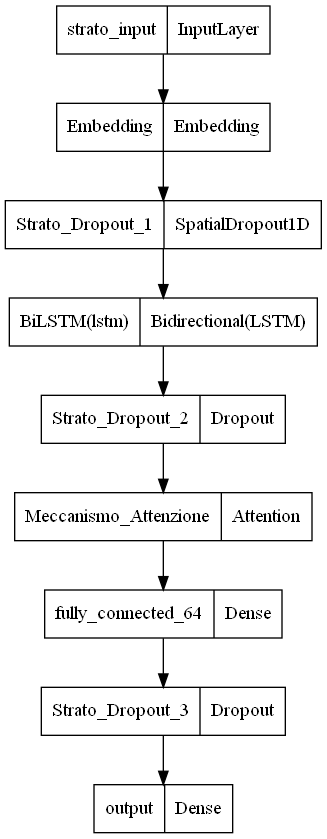

In [ ]:
#LSTM

inp2 = Input(shape=(X_tra.shape[1],), dtype='int32',name="strato_input")

# Strato di word embedding
embedded_inputs = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                            weights=[embedding_matrix], trainable = False, name="Embedding")(inp2)


# primo dropout
embedded_inputs = SpatialDropout1D(0.2,name="Strato_Dropout_1")(embedded_inputs)                 

# BiLSTM 
rnn_outs2 = Bidirectional(\
                LSTM(64, return_sequences=True),name="BiLSTM")(embedded_inputs)               
rnn_outs2 = Dropout(0.2, name="Strato_Dropout_2")(rnn_outs2) # Secondo dropout          

# Meccanismo di attenzione - generare vettori di attenzione 
sentence, word_scores2 = Attention(return_attention=True, name="Meccanismo_Attenzione")(rnn_outs2)

# strati densi
fc2 = Dense(64, activation='relu',name="fully_connected_64")(sentence)
fc2 = Dropout(0.5, name="Strato_Dropout_3")(fc2)                                                                              
output = Dense(1, activation='sigmoid',name="output")(fc2)

# Modello finale e metriche
model_lstm = Model(inputs=inp2, outputs=output)
model_lstm.compile(loss='binary_crossentropy', metrics=["accuracy"], optimizer='adam')

# sintesi del modello
model_lstm.summary()

#grafico del mmodello
plot_model(model_lstm, to_file="Bilstm.png")

DELETE

delete

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 strato_input (InputLayer)   [(None, 2904)]            0         
                                                                 
 Embedding (Embedding)       (None, 2904, 300)         3407700   
                                                                 
 Strato_Dropout_1 (SpatialDr  (None, 2904, 300)        0         
 opout1D)                                                        
                                                                 
 BiGRU (Bidirectional)       (None, 2904, 128)         140544    
                                                                 
 Strato_Dropout_2 (Dropout)  (None, 2904, 128)         0         
                                                                 
 Meccanismo_Attenzione (Atte  [(None, 128),            3032      
 ntion)                       (None, 2904)]                  

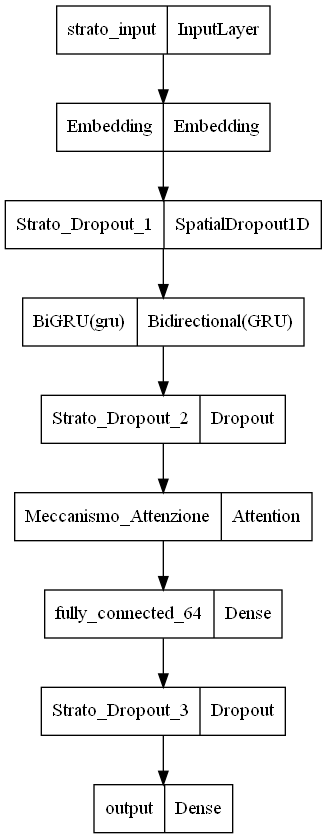

In [21]:
#GRU

inp = Input(shape=(X_tra.shape[1],), dtype='int32',name="strato_input")

# Strato di word embedding
embedded_inputs = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], 
                            weights=[embedding_matrix], trainable = False, name="Embedding")(inp)


# primo dropout
embedded_inputs = SpatialDropout1D(0.2,name="Strato_Dropout_1")(embedded_inputs)                   

# BiLSTM 
rnn_outs = Bidirectional(\
                GRU(64, return_sequences=True),name="BiGRU")(embedded_inputs)               
rnn_outs = Dropout(0.2, name="Strato_Dropout_2")(rnn_outs) # Secondo dropout          

# Meccanismo di attenzione - generare vettori di attenzione 
sentence, word_scores = Attention(return_attention=True, name="Meccanismo_Attenzione")(rnn_outs)

# strati densi
fc = Dense(64, activation='relu',name="fully_connected_64")(sentence)
fc = Dropout(0.5, name="Strato_Dropout_3")(fc)                                                                              
output = Dense(1, activation='sigmoid',name="output")(fc)

# Modello finale e metriche
model_gru = Model(inputs=inp, outputs=output)
model_gru.compile(loss='binary_crossentropy', metrics=["accuracy"], optimizer='adam')

# sintesi del modello
model_gru.summary()

#grafico del mmodello
plot_model(model_gru, to_file="Bigru.png")


TRAIN MODELLI

delete

delete

delete

delete

delete

delete

delete

delete

delete

delete

In [24]:
# Train LSTM

F1_Score = F1Evaluation(validation_data=(X_val, Y_val), interval=1)
hist_lstm=model_lstm.fit(X_tra, Y_tra, validation_data=(X_val, Y_val), epochs=70, batch_size=32,callbacks=[F1_Score])

val_loss_lstm = hist_lstm.history['val_loss'];val_acc_lstm = hist_lstm.history['val_accuracy']
loss_lstm = hist_lstm.history['loss'];acc_lstm = hist_lstm.history['accuracy']

Epoch 1/70
7/7 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.5909
 F1 Score - epoch: 1 - score: 0.414141 

7/7 [==============================] - 32s 4s/step - loss: 0.6916 - accuracy: 0.5909 - val_loss: 0.6803 - val_accuracy: 0.5859
Epoch 2/70
7/7 [==============================] - ETA: 0s - loss: 0.6811 - accuracy: 0.6111
 F1 Score - epoch: 2 - score: 0.414141 

7/7 [==============================] - 28s 4s/step - loss: 0.6811 - accuracy: 0.6111 - val_loss: 0.6763 - val_accuracy: 0.5859
Epoch 3/70
7/7 [==============================] - ETA: 0s - loss: 0.6804 - accuracy: 0.6111
 F1 Score - epoch: 3 - score: 0.414141 

7/7 [==============================] - 29s 4s/step - loss: 0.6804 - accuracy: 0.6111 - val_loss: 0.6774 - val_accuracy: 0.5859
Epoch 4/70
7/7 [==============================] - ETA: 0s - loss: 0.6784 - accuracy: 0.6111
 F1 Score - epoch: 4 - score: 0.414141 

7/7 [==============================] - 29s 4s/step - loss: 0.6784 - accuracy: 0.6111 - 


delete

delete

delete

delete

delete

delete

delete

In [22]:
#Train GRU
F1_Score = F1Evaluation(validation_data=(X_val, Y_val), interval=1)
hist_gru=model_gru.fit(X_tra, Y_tra, validation_data=(X_val, Y_val), epochs=70, batch_size=32,callbacks=[F1_Score])

val_loss_gru = hist_gru.history['val_loss'];val_acc_gru = hist_gru.history['val_accuracy']
loss_gru = hist_gru.history['loss'];acc_gru = hist_gru.history['accuracy']

Epoch 1/70
7/7 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5758
 F1 Score - epoch: 1 - score: 0.323232 

7/7 [==============================] - 30s 4s/step - loss: 0.6932 - accuracy: 0.5758 - val_loss: 0.6653 - val_accuracy: 0.6768
Epoch 2/70
7/7 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.5909
 F1 Score - epoch: 2 - score: 0.323232 

7/7 [==============================] - 26s 4s/step - loss: 0.6812 - accuracy: 0.5909 - val_loss: 0.6557 - val_accuracy: 0.6768
Epoch 3/70
7/7 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.5909
 F1 Score - epoch: 3 - score: 0.363636 

7/7 [==============================] - 26s 4s/step - loss: 0.6856 - accuracy: 0.5909 - val_loss: 0.6503 - val_accuracy: 0.6768
Epoch 4/70
7/7 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.5909
 F1 Score - epoch: 4 - score: 0.323232 

7/7 [==============================] - 25s 4s/step - loss: 0.6822 - accuracy: 0.5909 - 

delete

delete

delete

delete

delete

delete

delete

delete

delete

delete

delete

delete


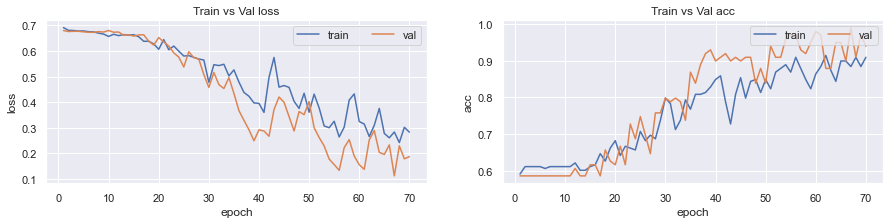

In [26]:
#plot LSTM

make_plot(loss_lstm, val_loss_lstm, acc_lstm, val_acc_lstm)

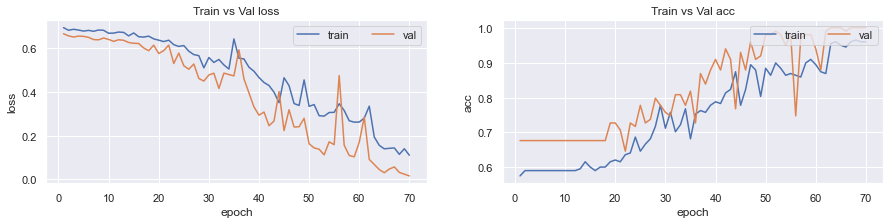

In [23]:
#plot GRU

make_plot(loss_gru, val_loss_gru, acc_gru, val_acc_gru)

best threshold f1

In [28]:
val_pred_lstm = model_lstm.predict([X_val], batch_size=32, verbose=1)
f1s = []
max_thresh_lstm, max_f1 = 0, 0
for thresh_lstm in np.arange(0.1, 0.9, 0.01):
    f1s.append(metrics.f1_score(Y_val, (val_pred_lstm>thresh_lstm)))
max_f1 = np.max(f1s)
max_thresh_lstm = np.arange(0.1, 0.9, 0.01)[np.argmax(f1s)]
print('Validation set lstm: F1-Score massimo: %.2f - raggiunto con una threshold: %.2f' % (max_f1, max_thresh_lstm))


val_pred_gru = model_gru.predict([X_val], batch_size=32, verbose=1)
f1s = []
max_thresh_gru, max_f1 = 0, 0
for thresh_gru in np.arange(0.1, 0.9, 0.01):
    f1s.append(metrics.f1_score(Y_val, (val_pred_gru>thresh_gru)))
max_f1 = np.max(f1s)
max_thresh_gru = np.arange(0.1, 0.9, 0.01)[np.argmax(f1s)]
print('Validation set gru: F1-Score massimo: %.2f - raggiunto con una threshold: %.2f' % (max_f1, max_thresh_gru))


4/4 [==============================] - 6s 1s/step
Validation set lstm: F1-Score massimo: 1.00 - raggiunto con una threshold: 0.18
4/4 [==============================] - 5s 1s/step
Validation set gru: F1-Score massimo: 1.00 - raggiunto con una threshold: 0.89


In [24]:
val_pred_gru = model_gru.predict([X_val], batch_size=32, verbose=1)
f1s = []
max_thresh_gru, max_f1 = 0, 0
for thresh_gru in np.arange(0.1, 0.9, 0.01):
    f1s.append(metrics.f1_score(Y_val, (val_pred_gru>thresh_gru)))
max_f1 = np.max(f1s)
max_thresh_gru = np.arange(0.1, 0.9, 0.01)[np.argmax(f1s)]
print('Validation set gru: F1-Score massimo: %.2f - raggiunto con una threshold: %.2f' % (max_f1, max_thresh_gru))



test_pred_gru = model_gru.predict([X_te], batch_size=32, verbose=1)
test_pred_thresh_gru = (test_pred_gru>max_thresh_gru).astype(int)


4/4 [==============================] - 5s 1s/step
Validation set gru: F1-Score massimo: 1.00 - raggiunto con una threshold: 0.13
4/4 [==============================] - 5s 1s/step


delete

In [29]:
#predizioni lstm

test_pred_lstm = model_lstm.predict([X_te], batch_size=32, verbose=1)
test_pred_thresh_lstm = (test_pred_lstm>max_thresh_lstm).astype(int)

#predizioni gru

test_pred_gru = model_gru.predict([X_te], batch_size=32, verbose=1)
test_pred_thresh_gru = (test_pred_gru>max_thresh_gru).astype(int)

4/4 [==============================] - 5s 1s/step


Accuratezza del modello:  0.9797979797979798


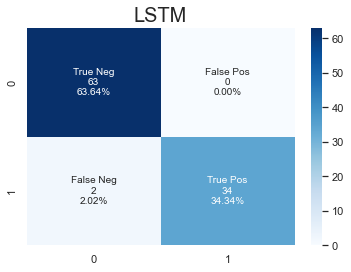

In [30]:
#Confusion Matrix LSTM

print("Accuratezza del modello: ", accuracy_score(test_pred_thresh_lstm, Y_te))

cm_lstm=confusion_matrix(Y_te,test_pred_thresh_lstm)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm_lstm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_lstm.flatten()/np.sum(cm_lstm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm_lstm, annot=labels, fmt='', cmap='Blues')
plt.figure(1,figsize=(16,4), dpi=300)
plt.title("LSTM",fontsize = 20)
plt.savefig("confma_lstm.png", dpi=300)

Accuratezza del modello:  0.98989898989899


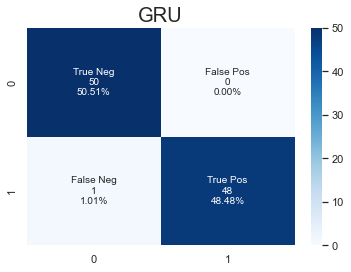

In [25]:
#Confusion Matrix GRU

print("Accuratezza del modello: ", accuracy_score(test_pred_thresh_gru, Y_te))

cm_gru=confusion_matrix(Y_te,test_pred_thresh_gru)

group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cm_gru.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm_gru.flatten()/np.sum(cm_gru)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cm_gru, annot=labels, fmt='', cmap='Blues')
plt.figure(1,figsize=(16,4), dpi=300)
plt.title("GRU",fontsize = 20)
plt.savefig("confma_gru.png", dpi=300)

    SCELTO IL MODELLO MIGLIORE: OUTPUT SU CSV

In [31]:
out_df = pd.DataFrame({"ID":test_df["ID"].values}) 
out_df['prediction'] = test_pred_thresh_gru
out_df.to_csv("pred.csv", index=False)
out_df.head()

,ID,prediction
0,230,1
1,204,0
2,324,0
3,349,1
4,164,0


1/1 [==============================] - 1s 811ms/step


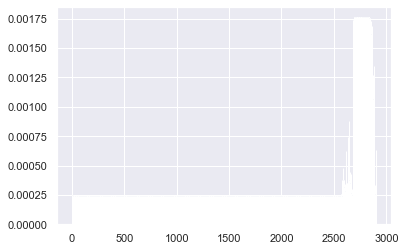

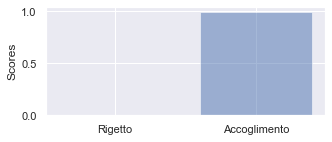

1/1 [==============================] - 1s 762ms/step


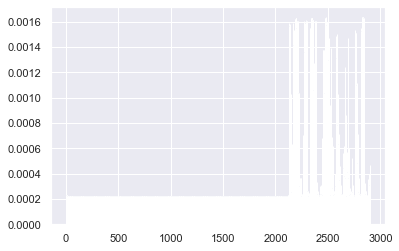

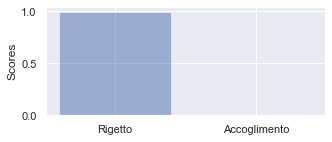

1/1 [==============================] - 1s 751ms/step


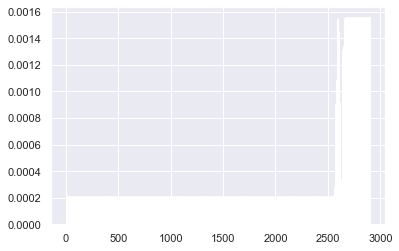

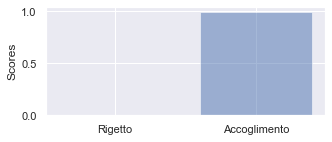

In [29]:
for _ in range(3):
    visualize_attention()

LIME
delete

delete

delete

delete

delete

delete

delete 

In [46]:
from lime.lime_text import LimeTextExplainer

class_names=['Rigetto','Accoglimento']
explainer= LimeTextExplainer(class_names=class_names)
def predict_proba(arr):
  processed=[]
  for i in arr:
    processed.append(preprocess(i))
  list_tokenized_ex = tokenizer.texts_to_sequences(processed)
  Ex = pad_sequences(list_tokenized_ex, maxlen=MAX_LEN)
  pred=model_gru.predict(Ex)
  returnable=[]
  for i in pred:
    temp=i[0]
    returnable.append(np.array([1-temp,temp])) 
  return np.array(returnable)

In [47]:
lime_Data_result.replace({0:"Rigetto", 1:"Accoglimento"} ,inplace=True)

print("valore etichetta:",lime_Data_result[72])

explainer.explain_instance(lime_Data_text[72],predict_proba).show_in_notebook(text=True)

valore etichetta: Rigetto
157/157 [==============================] - 245s 2s/step


N-GRAMS ANALYSIS

In [15]:
from collections import defaultdict
import string

n_gram_df=n_gram_df.drop(columns=['ID',"Created At", "Text", "text_lenght"])

def remove_punctuation(text):
  if(type(text)==float):
    return text
  ans=""  
  for i in text:     
    if i not in string.punctuation:
      ans+=i    
  return ans

n_gram_df['clean_text']= n_gram_df['clean_text'].apply(lambda x:remove_punctuation(x))



delete 

delete

In [16]:
positiveValues=defaultdict(int)
negativeValues=defaultdict(int)

def generate_N_grams(text,ngram=2):
  words=[word for word in text.split(" ")] 
  temp=zip(*[words[i:] for i in range(0,ngram)])
  ans=[' '.join(ngram) for ngram in temp]
  return ans

In [17]:
for text in n_gram_df[n_gram_df.Result==0].clean_text:
  for word in generate_N_grams(text):
    negativeValues[word]+=1
    


In [18]:
for text in n_gram_df[n_gram_df.Result==1].clean_text:
  for word in generate_N_grams(text):
    positiveValues[word]+=1

In [19]:
df_positive=pd.DataFrame(sorted(positiveValues.items(),key=lambda x:x[1],reverse=True))
df_negative=pd.DataFrame(sorted(negativeValues.items(),key=lambda x:x[1],reverse=True))

In [20]:
pd1=df_positive[0][:15]
pd2=df_positive[1][:15]

ned1=df_negative[0][:15]
ned2=df_negative[1][:15]

In [46]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 20),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':28}
pylab.rcParams.update(params)

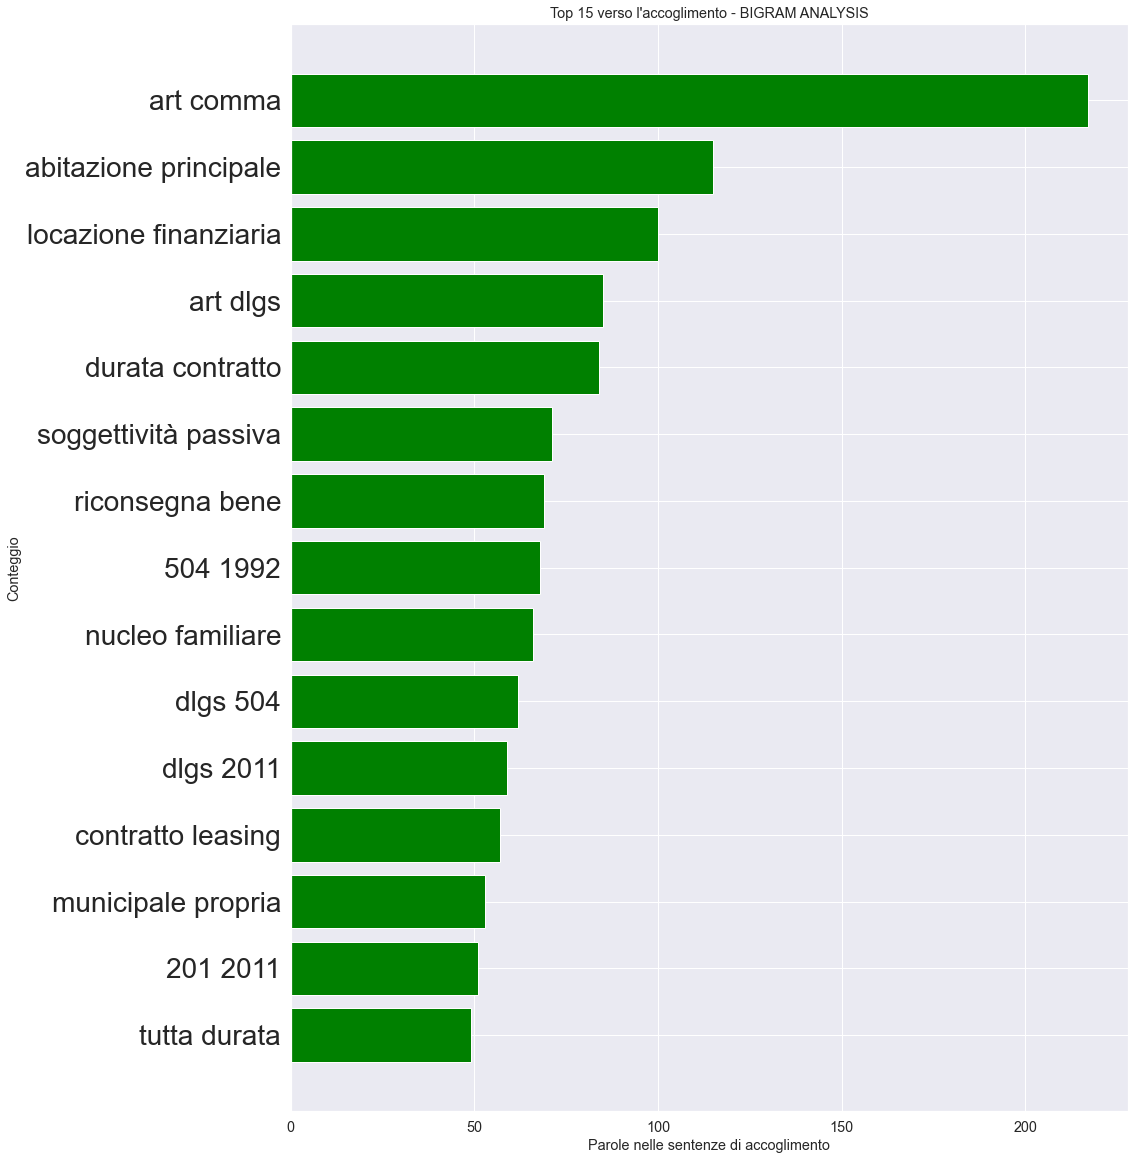

In [49]:
plt.barh(pd1,pd2, color ='green')
plt.xlabel("Parole nelle sentenze di accoglimento")
plt.ylabel("Conteggio")
plt.title("Top 15 verso l'accoglimento - BIGRAM ANALYSIS")
plt.gca().invert_yaxis()
plt.savefig("positive-bigram.png", dpi=300, bbox_inches='tight')
plt.show()

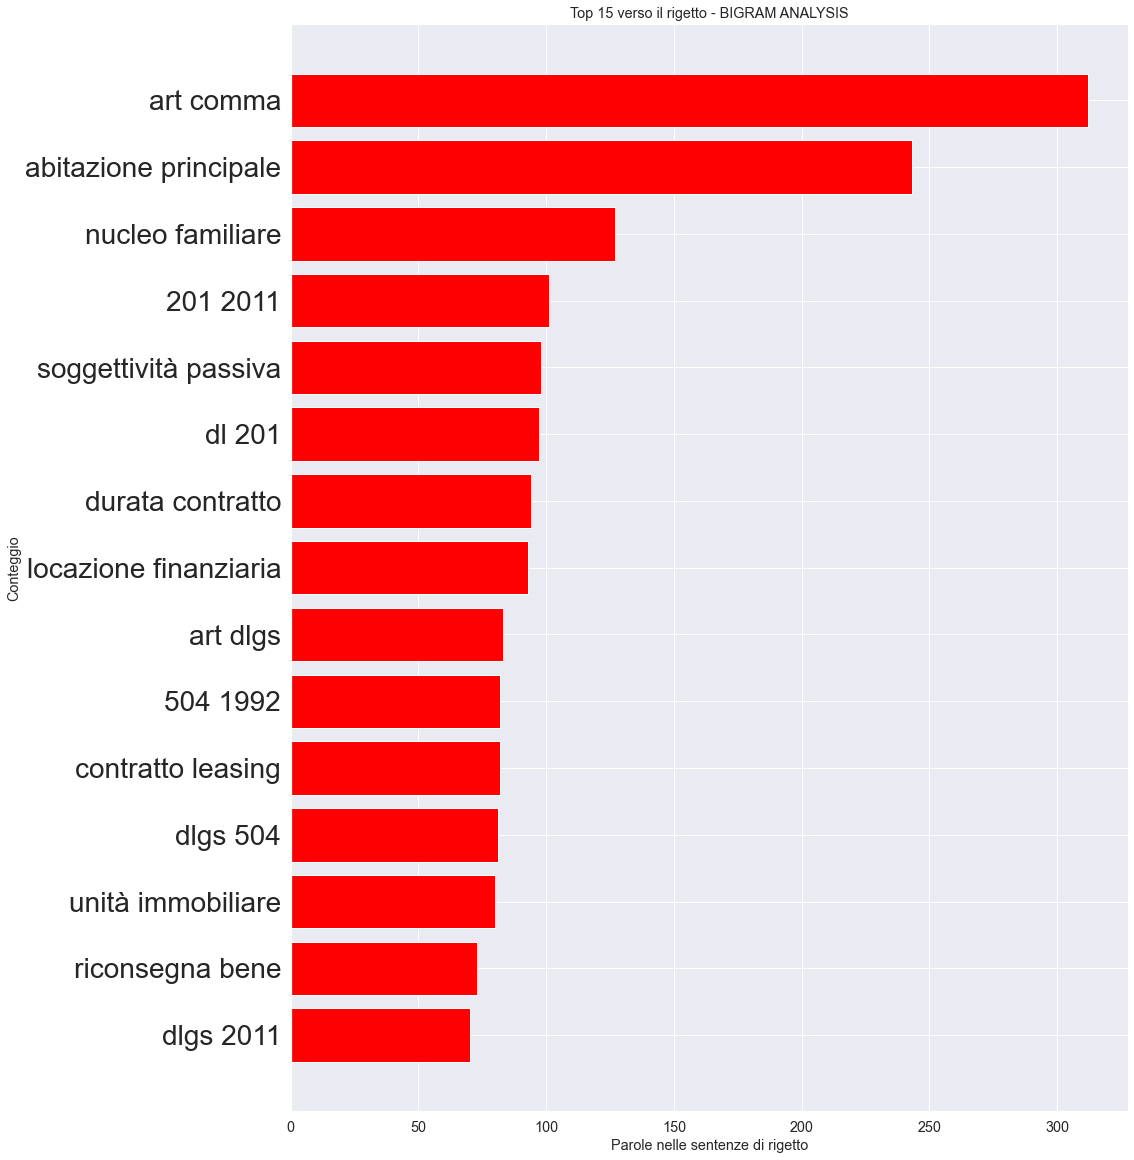

In [50]:
plt.barh(ned1,ned2, color ='red')
plt.xlabel("Parole nelle sentenze di rigetto")
plt.gca().invert_yaxis()
plt.ylabel("Conteggio")
plt.title("Top 15 verso il rigetto - BIGRAM ANALYSIS")
plt.savefig("negative-bigram.png", dpi=300, bbox_inches='tight')
plt.show()

delete 

delete

delete 

delete

delete 

delete

delete 

delete

4-GRAM

In [29]:
positiveValues4=defaultdict(int)
negativeValues4=defaultdict(int)

for text in n_gram_df[n_gram_df.Result==0].clean_text:
  for word in generate_N_grams(text,4):
    negativeValues4[word]+=1

for text in n_gram_df[n_gram_df.Result==1].clean_text:
  for word in generate_N_grams(text,4):
    positiveValues4[word]+=1

df_positive4=pd.DataFrame(sorted(positiveValues4.items(),key=lambda x:x[1],reverse=True))
df_negative4=pd.DataFrame(sorted(negativeValues4.items(),key=lambda x:x[1],reverse=True))

pd1_4=df_positive4[0][:20]
pd2_4=df_positive4[1][:20]

ned1_4=df_negative4[0][:20]
ned2_4=df_negative4[1][:20]

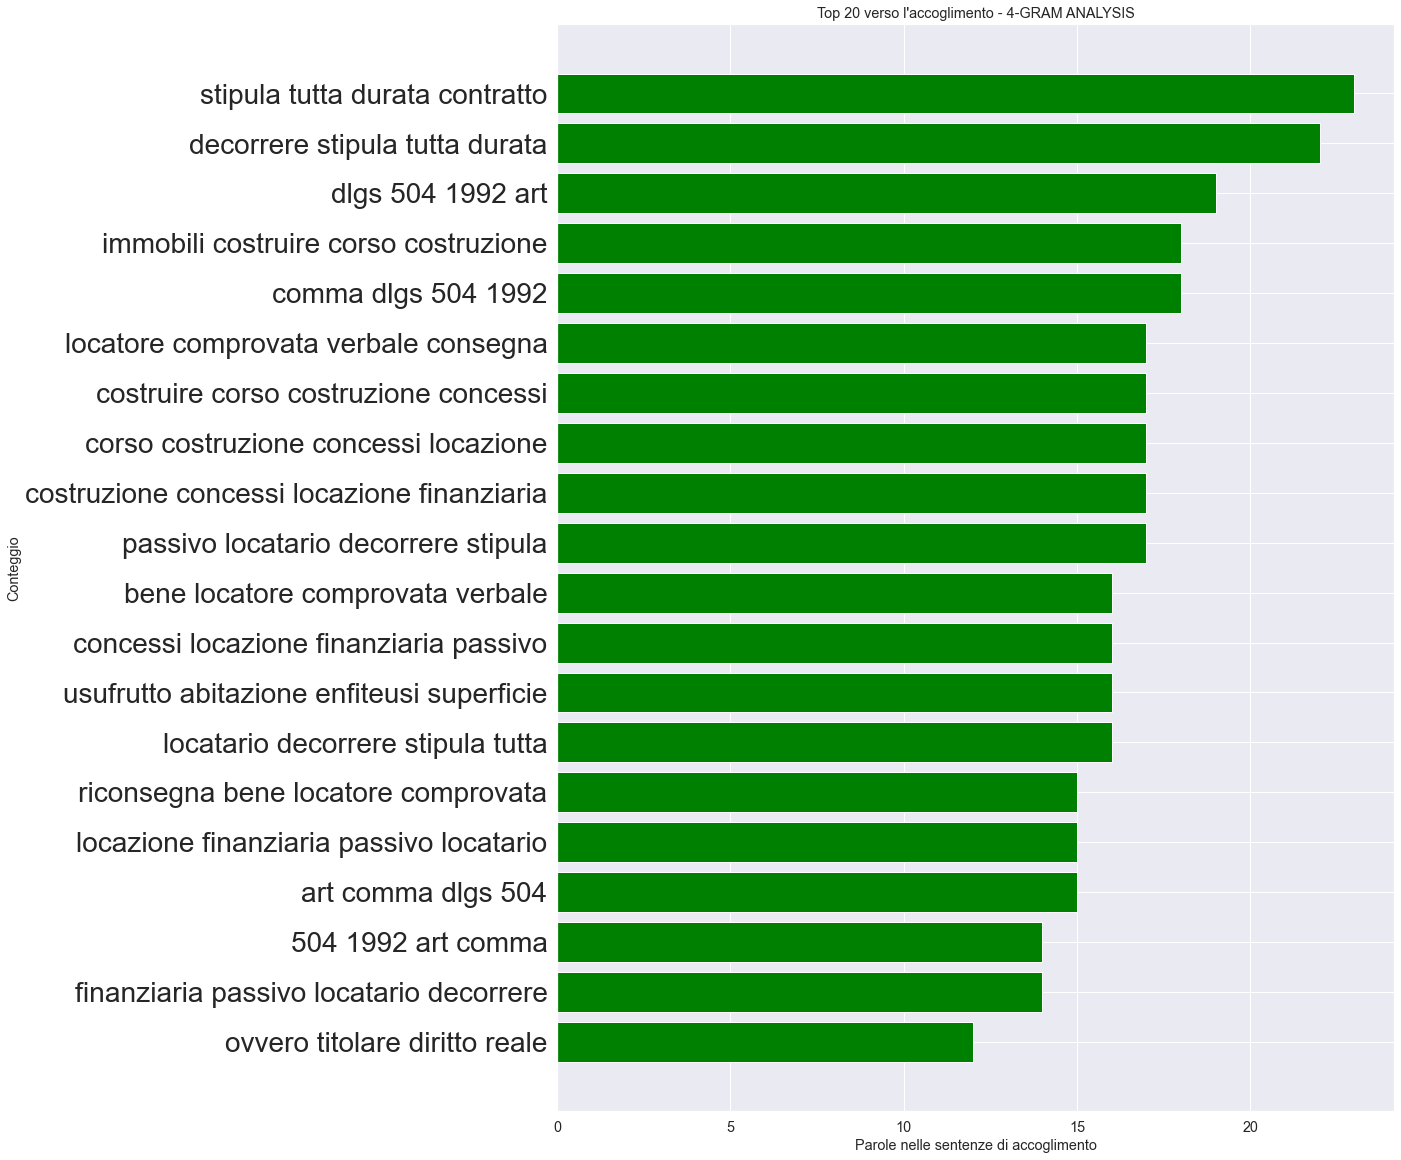

In [52]:
plt.barh(pd1_4,pd2_4, color ='green')
plt.xlabel("Parole nelle sentenze di accoglimento")
plt.ylabel("Conteggio")
plt.title("Top 20 verso l'accoglimento - 4-GRAM ANALYSIS")
plt.gca().invert_yaxis()
plt.savefig("positive-4gram.png",dpi=300, bbox_inches='tight')
plt.show()

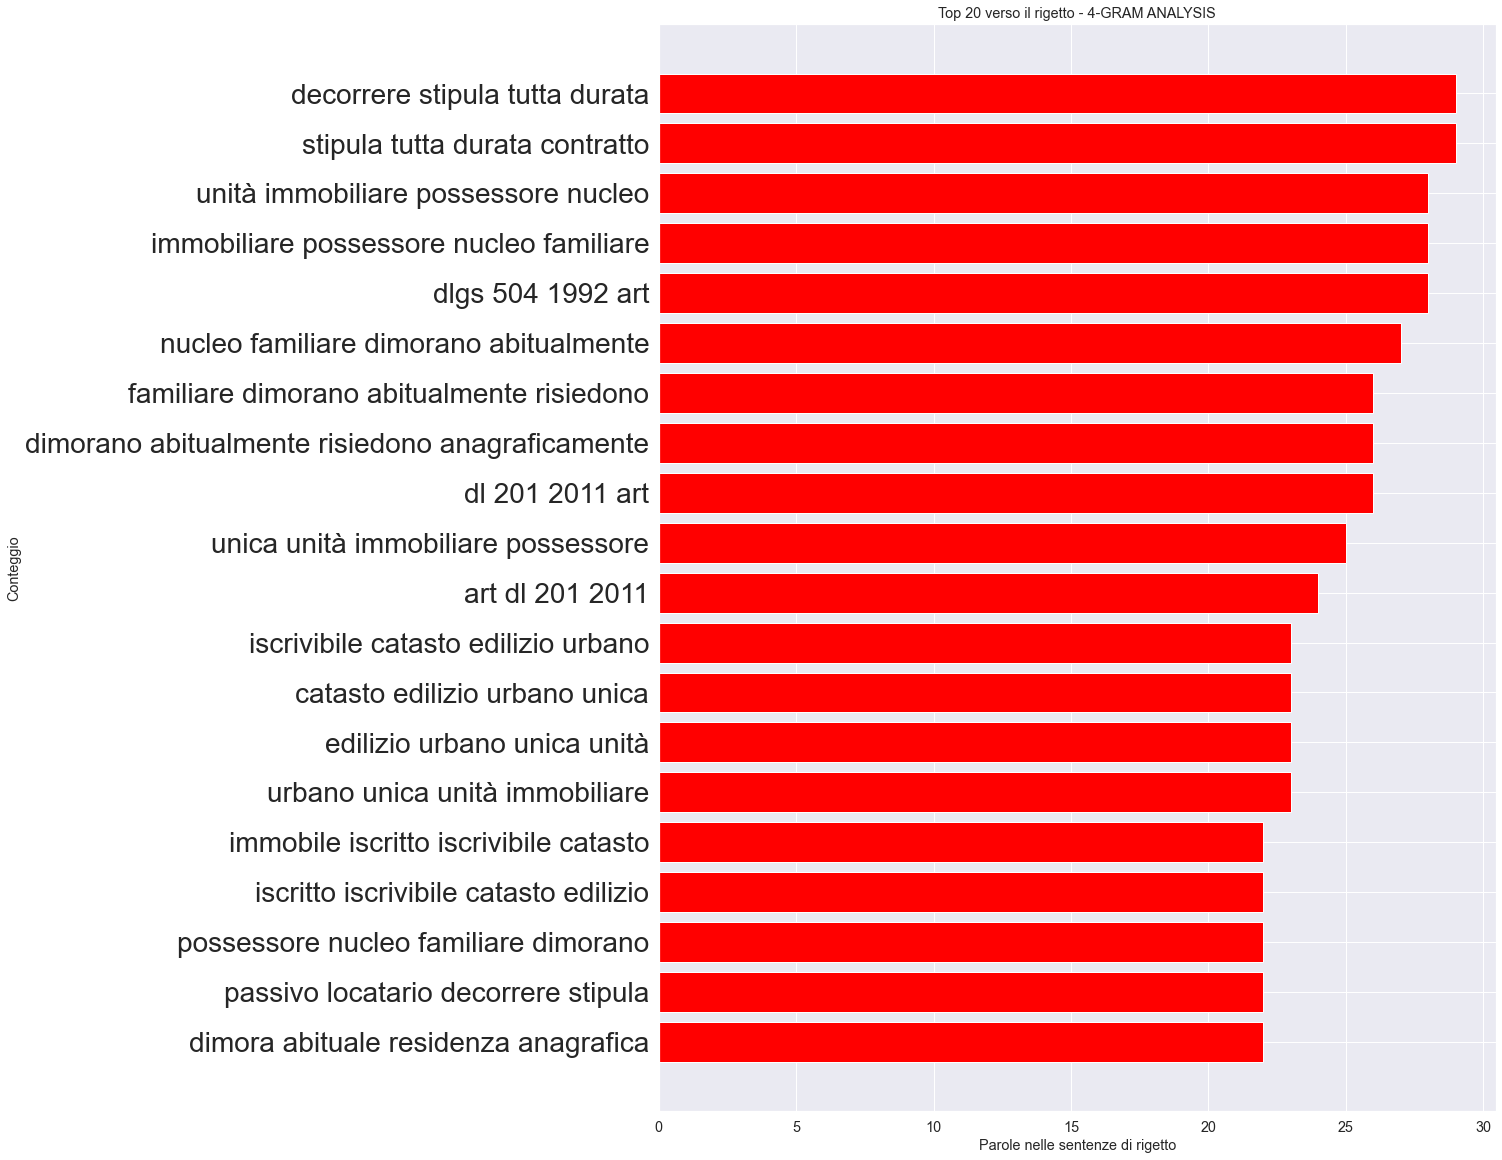

In [53]:
plt.barh(ned1_4,ned2_4, color ='red') 
plt.xlabel("Parole nelle sentenze di rigetto")
plt.yticks(wrap=True)
plt.ylabel("Conteggio")
plt.title("Top 20 verso il rigetto - 4-GRAM ANALYSIS")
plt.gca().invert_yaxis()
plt.savefig("negative-4gram.png",dpi=300, bbox_inches='tight')
plt.show()

5-GRAM

delete 

delete

delete 

delete

delete 

delete

delete 

delete

delete

delete

In [32]:
positiveValues5=defaultdict(int)
negativeValues5=defaultdict(int)

for text in n_gram_df[n_gram_df.Result==0].clean_text:
  for word in generate_N_grams(text,5):
    negativeValues5[word]+=1

for text in n_gram_df[n_gram_df.Result==1].clean_text:
  for word in generate_N_grams(text,5):
    positiveValues5[word]+=1
    
df_positive5=pd.DataFrame(sorted(positiveValues5.items(),key=lambda x:x[1],reverse=True))
df_negative5=pd.DataFrame(sorted(negativeValues5.items(),key=lambda x:x[1],reverse=True))

pd1_5=df_positive5[0][:20]
pd2_5=df_positive5[1][:20]

ned1_5=df_negative5[0][:20]
ned2_5=df_negative5[1][:20]

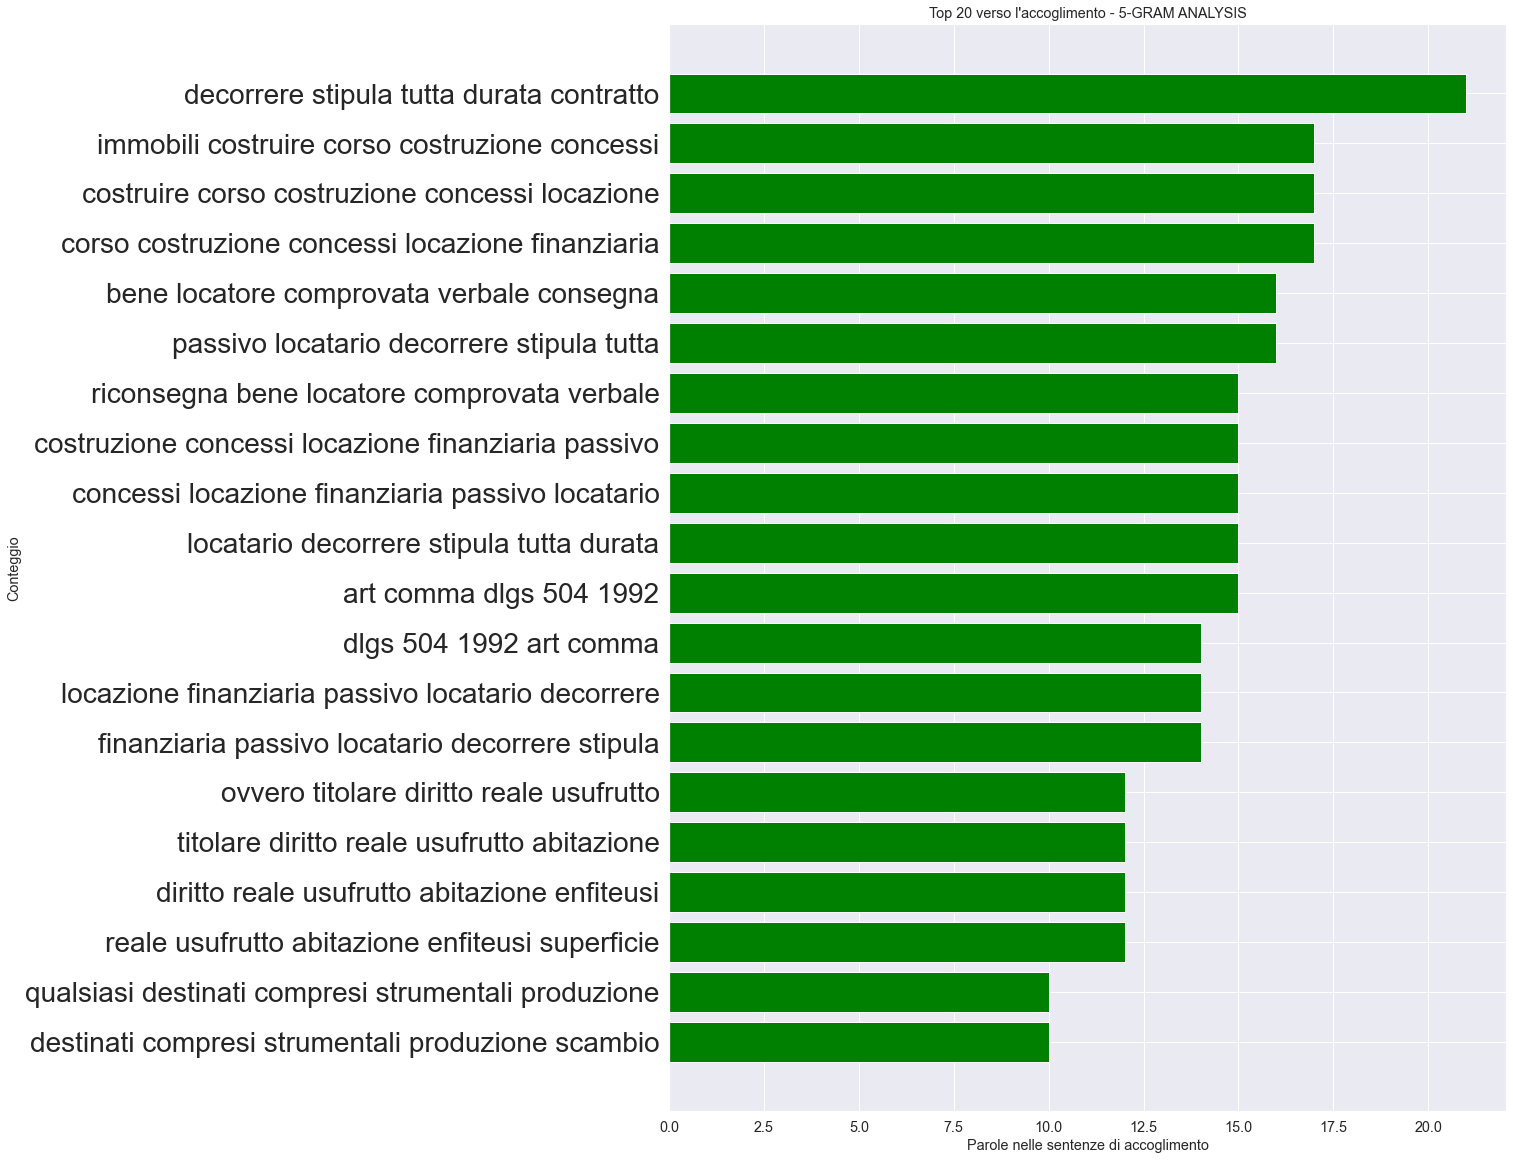

In [54]:
plt.barh(pd1_5,pd2_5, color ='green')
plt.xlabel("Parole nelle sentenze di accoglimento")
plt.ylabel("Conteggio")
plt.title("Top 20 verso l'accoglimento - 5-GRAM ANALYSIS")
plt.gca().invert_yaxis()
plt.savefig("positive-5gram.png",dpi=300, bbox_inches='tight')
plt.show()

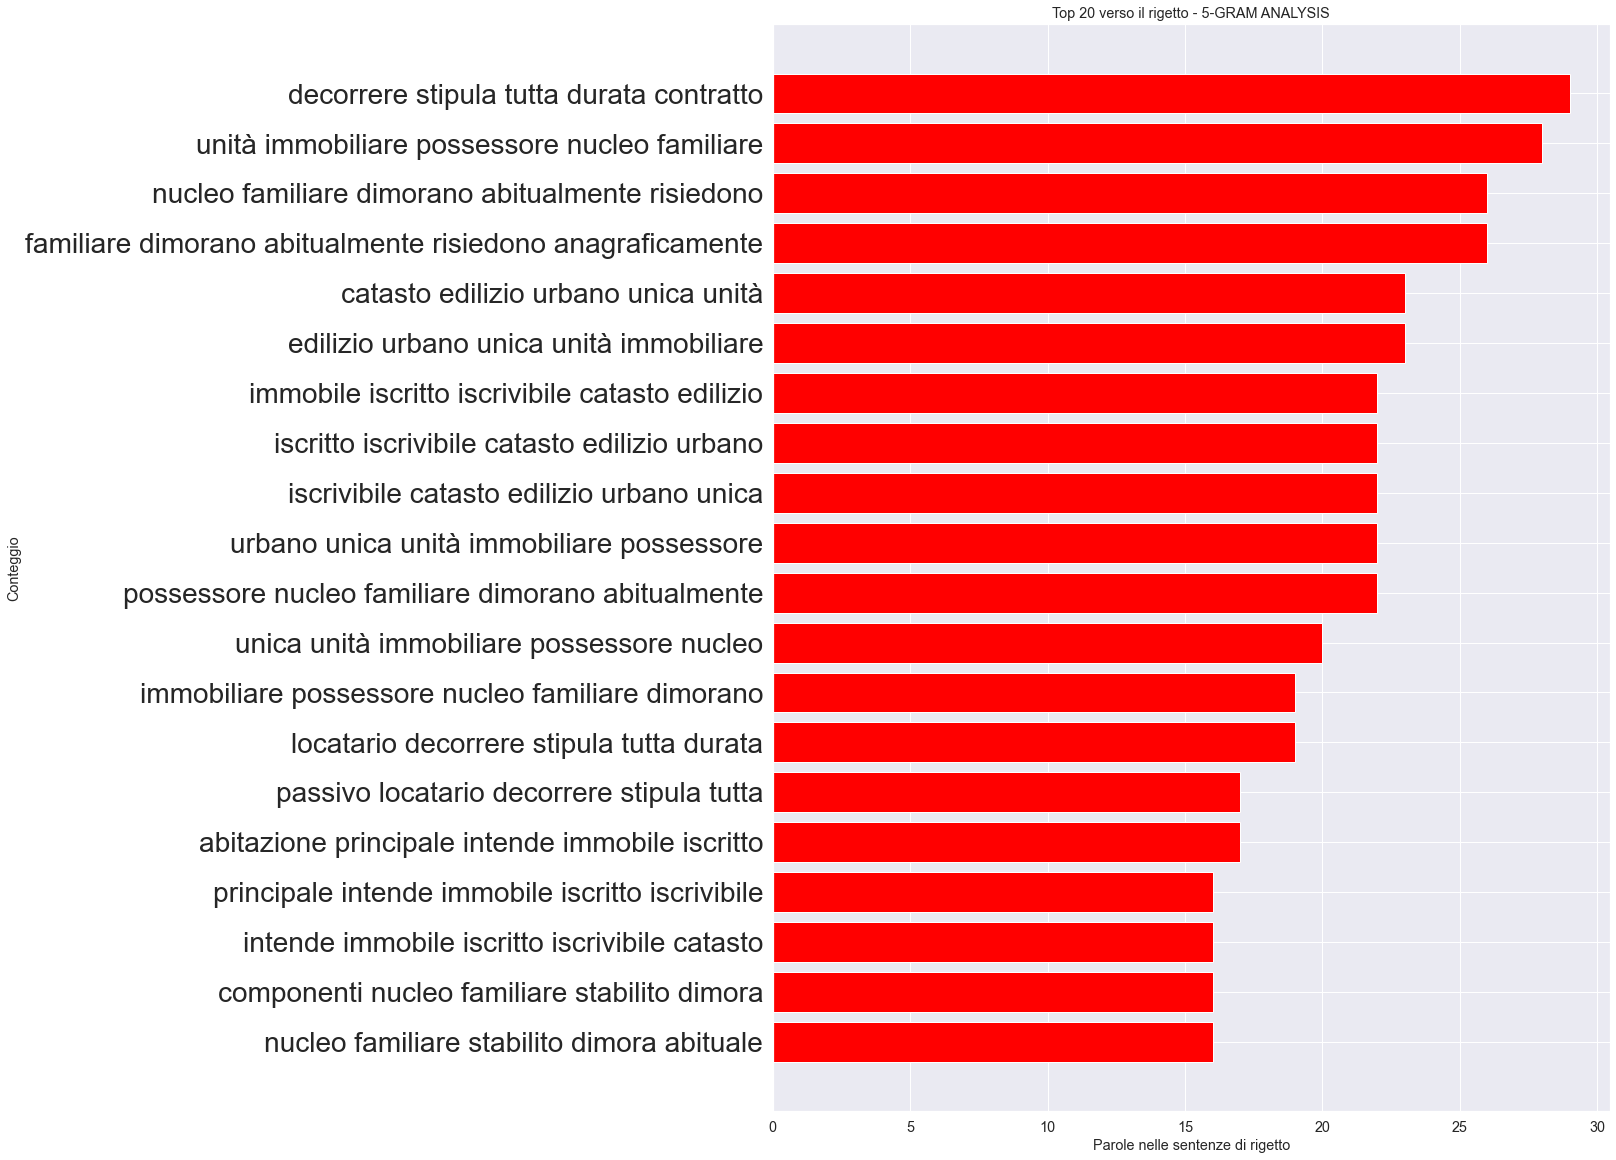

: 

In [55]:
plt.barh(ned1_5,ned2_5, color ='red') 
plt.xlabel("Parole nelle sentenze di rigetto")
plt.yticks(wrap=True)
plt.ylabel("Conteggio")
plt.title("Top 20 verso il rigetto - 5-GRAM ANALYSIS")
plt.gca().invert_yaxis()
plt.savefig("negative-5gram.png",dpi=300, bbox_inches='tight')
plt.show()